# Regresión Logística como introducción a las redes neuronales

Vamos a construir un clasificador de regresión logística para reconocer gatos. Esta tarea te guiará a hacerlo con una mentalidad de red neuronal y, además, fortalecerá tus intuiciones sobre el aprendizaje profundo.

**Instrucciones:**
- No utilices bucles (for/while) en tu código, a menos que las instrucciones lo pidan explícitamente.

**Aprenderás a:**
- Construir la arquitectura general de un algoritmo de aprendizaje, que incluye:
    - Inicialización de parámetros
    - Cálculo de la función de costo y su gradiente
    - Uso de un algoritmo de optimización (descenso de gradiente)
- Reunir las tres funciones anteriores en una función principal del modelo, en el orden correcto.

## 1 - Paquetes ##

Primero, ejecutemos la celda de abajo para importar todos los paquetes que necesitarás durante esta tarea.  
- [numpy](www.numpy.org) es el paquete fundamental para la computación científica con Python.  
- [h5py](http://www.h5py.org) es un paquete común para interactuar con un conjunto de datos almacenado en un archivo H5.  
- [matplotlib](http://matplotlib.org) es una biblioteca famosa para graficar en Python.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from lr_utils import load_dataset

%matplotlib inline

## 2 - Visión general del conjunto de ejercicios ##

**Enunciado del problema**: Se te proporciona un conjunto de datos ("data.h5") que contiene:  
- un conjunto de entrenamiento de m_train imágenes etiquetadas como gato (y=1) o no gato (y=0)  
- un conjunto de prueba de m_test imágenes etiquetadas como gato o no gato  
- cada imagen tiene forma (num_px, num_px, 3), donde 3 corresponde a los 3 canales (RGB). Por lo tanto, cada imagen es cuadrada (altura = num_px, ancho = num_px).  

Construirás un algoritmo sencillo de reconocimiento de imágenes que pueda clasificar correctamente las imágenes como gato o no gato.

Familiaricémonos más con el conjunto de datos. Carga los datos ejecutando el siguiente código.

In [2]:
# Cargar el dataset (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Agregamos "_orig" al final de los conjuntos de datos de imágenes (train y test) porque los vamos a preprocesar. Después del preprocesamiento, obtendremos train_set_x y test_set_x (las etiquetas train_set_y y test_set_y no necesitan ningún preprocesamiento).

Cada línea de tus train_set_x_orig y test_set_x_orig es un array que representa una imagen. Puedes visualizar un ejemplo ejecutando el siguiente código. Puedes cambiar el valor de `index` y volver a ejecutar para ver otras imágenes.

y = [1], cat


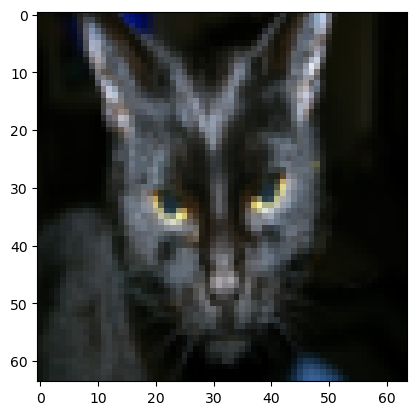

In [3]:
# Dibujamos un caso del dataset
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", " + classes[np.squeeze(train_set_y[:, index])].decode("utf-8"))


Muchos errores provienen de dimensiones de matrices/vectores que no coinciden. Si logras mantener las dimensiones de matrices/vectores en orden, avanzarás mucho en la eliminación de muchos errores.

**Ejercicio:** Encuentra los valores de:
- `m_train` (número de ejemplos de entrenamiento)
- `m_test` (número de ejemplos de prueba)
- `num_px` (= altura = ancho de una imagen de entrenamiento)

Recuerda que `train_set_x_orig` es un array de numpy con la forma `(m_train, num_px, num_px, 3)`. Por ejemplo, puedes acceder a `m_train` escribiendo `train_set_x_orig.shape[0]`.

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig[0].shape[0]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Salida esperada para `m_train`, `m_test` y `num_px`**:  
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
</table>

Para mayor comodidad, ahora deberías reestructurar las imágenes con forma `(num_px, num_px, 3)` en un array de numpy con forma `(num_px * num_px * 3, 1)`. Después de esto, nuestro conjunto de datos de entrenamiento (y prueba) será un array de numpy donde cada columna representa una imagen aplanada. Debe haber `m_train` (o respectivamente `m_test`) columnas.

**Ejercicio:** Reestructura los conjuntos de datos de entrenamiento y prueba de modo que las imágenes de tamaño `(num_px, num_px, 3)` se aplanen en vectores individuales con forma `(num_px * num_px * 3, 1)`.

Un truco cuando deseas aplanar una matriz `X` con forma `(a, b, c, d)` en una matriz `X_flatten` con forma `(b * c * d, a)` es usar:  
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T es la transpuesta de X
```

In [5]:
# Reshape el dataset de entrenamiento y test

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Salida esperada**:  

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td>(12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
    <td>**verificación de coherencia después de reestructurar**</td>
    <td>[17 31 56 22 33]</td> 
  </tr>
</table>

Para representar imágenes a color, se deben especificar los canales rojo, verde y azul (RGB) para cada píxel. Por lo tanto, el valor de un píxel es, en realidad, un vector de tres números que van de 0 a 255.

Un paso común de preprocesamiento en el aprendizaje automático es centrar y estandarizar tu conjunto de datos, lo que significa restar la media de todo el array de numpy a cada ejemplo y luego dividir cada ejemplo por la desviación estándar de todo el array de numpy. Sin embargo, para conjuntos de datos de imágenes, es más simple, conveniente y casi igual de efectivo simplemente dividir cada fila del conjunto de datos por 255 (el valor máximo de un canal de píxeles).

Estandaricemos nuestro conjunto de datos.

In [6]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 3 - Algoritmo ##

**Expresión matemática del algoritmo**:

Para un ejemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

El coste se calcula luego sumando sobre todos los ejemplos de entrenamiento:  
$$J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)}) \tag{6}$$



**Pasos clave**:  
En este ejercicio, llevarás a cabo los siguientes pasos:  
- Inicializar los parámetros del modelo.  
- Aprender los parámetros del modelo minimizando el costo.  
- Usar los parámetros aprendidos para hacer predicciones (en el conjunto de prueba).  
- Analizar los resultados y sacar conclusiones.

## 4 - Construyendo las partes de nuestro algoritmo ##

Los pasos principales para construir una Red Neuronal son:  
1. Definir la estructura del modelo (como el número de características de entrada).  
2. Inicializar los parámetros del modelo.  
3. Bucle:  
    - Calcular la pérdida actual (propagación hacia adelante).  
    - Calcular el gradiente actual (propagación hacia atrás).  
    - Actualizar los parámetros (descenso de gradiente).  

A menudo, los pasos 1-3 se construyen por separado y luego se integran en una función que llamamos `model()`.

### 4.1 - Funciones auxiliares

implementa `sigmoid()`:  
$$sigmoid(w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$
Utiliza `np.exp()`.

In [7]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [8]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Salida esperada**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Inicialización de parámetros

**Ejercicio:** Implementa la inicialización de parámetros en la celda a continuación. Debes inicializar \( w \) como un vector de ceros. Si no sabes qué función de numpy usar, consulta la documentación de la biblioteca de Numpy sobre `np.zeros()`.

In [9]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros([dim, 1])
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [10]:
dim = 4
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]
 [0.]]
b = 0


**Salida esperada**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Propagación hacia adelante y hacia atrás

Ahora que tus parámetros están inicializados, puedes realizar los pasos de "propagación hacia adelante" y "propagación hacia atrás" para aprender los parámetros.

**Ejercicio:** Implementa una función `propagate()` que calcule la función de costo y su gradiente.

**Pistas**:

Propagación hacia adelante:
- Tienes X
- Calculas $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- Funcion de costes: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Propagación hacia atras:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [11]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)                                 # compute activation
    cost = -np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m     # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m
    ### END CODE HERE ###
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


**Salida esperada**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.499935230625 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 6.000064773192205</td>
    </tr>

</table>

### d) Optimización

- Has inicializado tus parámetros.  
- También eres capaz de calcular una función de costo y su gradiente.  
- Ahora, deseas actualizar los parámetros utilizando el descenso de gradiente.  

**Ejercicio:** Escribe la función de optimización. El objetivo es aprender \( w \) y \( b \) minimizando la función de costo \( J \). Para un parámetro $\theta $, la regla de actualización es: 
 $$\theta = \theta - \alpha \, d\theta$$
donde $\alpha$ es la tasa de aprendizaje.

In [13]:
# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Salida esperada**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.1124579 ]
 [ 0.23106775]] </td>
    </tr>
    <tr>
       <td> **b** </td>
       <td> 1.55930492484 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.90158428]
 [ 1.76250842]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.430462071679 </td>
    </tr>

</table>

**Ejercicio:** La función anterior proporcionará los valores aprendidos de w  y b . Ahora podemos usar w  y b  para predecir las etiquetas de un conjunto de datos  X . Implementa la función `predict()`. Hay dos pasos para calcular las predicciones:

1. Calcula  
   $$ \hat{Y} = A = \sigma(w^T X + b) $$

2. Convierte las entradas de A en 0 (si la activación  $\leq 0.5$) o 1 (si la activación > 0.5), y almacena las predicciones en un vector `Y_prediction`. Si lo prefieres, puedes usar una declaración `if`/`else` dentro de un bucle `for` (aunque también hay una forma de vectorizar esto).

In [15]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m), dtype=int)
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0][i] = 1 if A[0][i] > 0.5 else 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [16]:
print ("predictions = " + str(predict(w, b, X)))
print(X)

predictions = [[1 1]]
[[1 2]
 [3 4]]


**Salida esperada**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1  1]]
         </td>  
   </tr>

</table>


## 5 - Unir todas las funciones en un modelo ##

Ahora verás cómo se estructura el modelo general combinando todos los bloques de construcción (funciones implementadas en las partes anteriores) en el orden correcto.

**Ejercicio:** Implementa la función del modelo. Usa la siguiente notación:
- `Y_prediction` para tus predicciones en el conjunto de prueba.  
- `Y_prediction_train` para tus predicciones en el conjunto de entrenamiento.  
- `w`, `costs`, `grads` para las salidas de `optimize()`.  

In [17]:
# FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Entrenar el modelo

In [18]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147


Cost after iteration 100: 0.591289
Cost after iteration 200: 0.555796
Cost after iteration 300: 0.528977
Cost after iteration 400: 0.506881
Cost after iteration 500: 0.487880
Cost after iteration 600: 0.471108
Cost after iteration 700: 0.456046
Cost after iteration 800: 0.442350
Cost after iteration 900: 0.429782
Cost after iteration 1000: 0.418164
Cost after iteration 1100: 0.407362
Cost after iteration 1200: 0.397269
Cost after iteration 1300: 0.387802
Cost after iteration 1400: 0.378888
Cost after iteration 1500: 0.370471
Cost after iteration 1600: 0.362500
Cost after iteration 1700: 0.354934
Cost after iteration 1800: 0.347737
Cost after iteration 1900: 0.340877
train accuracy: 91.38755980861244 %
test accuracy: 68.0 %


**Salida esperada**: 

<table style="width:40%"> 
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>**Test Accuracy** </td> 
        <td> 68.0 % </td>
    </tr>
</table> 




**Comentario**: La precisión en el entrenamiento está cerca del 100%. Esto es una buena verificación de coherencia: tu modelo está funcionando y tiene la capacidad suficiente para ajustarse a los datos de entrenamiento. El error en el conjunto de prueba es del 68%. En realidad, no está mal para este modelo simple, dado el pequeño conjunto de datos que usamos y que la regresión logística es un clasificador lineal. 

Hay que recordar que hay que comparar esta precisión con la de un clasificador trivial, uno que contestara completamente al azar, y acertaría un 50%. Es decir, hemos mejorado este 50% hasta un 68%.

Además, puedes ver que el modelo está claramente sobreajustando los datos de entrenamiento. Más adelante en esta especialización, aprenderás cómo reducir el sobreajuste, por ejemplo, utilizando regularización. 

Usando el código a continuación (y cambiando la variable `index`), puedes observar las predicciones en imágenes del conjunto de prueba.

y = 0 prediccion = non-cat


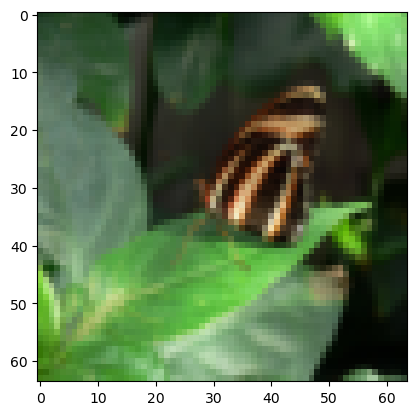

In [19]:
# Ejemplos
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]), "prediccion = " + classes[d["Y_prediction_test"][0,index]].decode("utf-8"))

Dibujamos la curva de entrenamiento

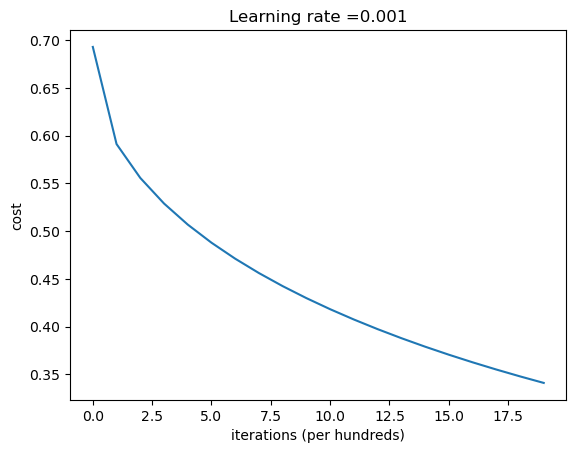

In [20]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretación**:  
Puedes observar que el coste está disminuyendo, lo cual indica que los parámetros están siendo aprendidos. Sin embargo, también puedes notar que podrías entrenar el modelo aún más en el conjunto de entrenamiento. Intenta aumentar el número de iteraciones en la celda anterior y vuelve a ejecutar las celdas. Es posible que veas que la precisión en el conjunto de entrenamiento aumenta, pero la precisión en el conjunto de prueba disminuye. Esto se llama sobreajuste.

## 6 - Cambiar learning rate



#### Elección de la tasa de aprendizaje ####

**Recordatorio**:  
Para que el Descenso de Gradiente funcione, debes elegir la tasa de aprendizaje \( \alpha \) de manera adecuada. La tasa de aprendizaje determina cómo de rápido actualizamos los parámetros. Si la tasa de aprendizaje es demasiado grande, podemos "sobrepasar" el valor óptimo. De manera similar, si es demasiado pequeña, necesitaremos demasiadas iteraciones para converger a los mejores valores. Por eso es crucial utilizar una tasa de aprendizaje bien ajustada.

Comparemos la curva de aprendizaje de nuestro modelo con varias elecciones de tasas de aprendizaje. Ejecuta la celda a continuación. Esto debería tomar aproximadamente 1 minuto. Puedes probar valores diferentes a los tres que hemos inicializado en la variable `learning_rates` y observa qué sucede.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



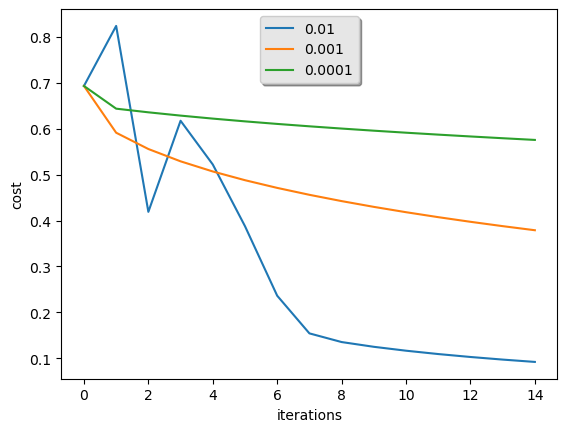

In [21]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretación**:  
- Diferentes tasas de aprendizaje producen diferentes costes y, por lo tanto, diferentes resultados en las predicciones.  
- Si la tasa de aprendizaje es demasiado grande (por ejemplo, 0.01), el coste puede oscilar hacia arriba y hacia abajo. Incluso puede diverger (aunque en este ejemplo, usar 0.01 eventualmente conduce a un buen valor para el coste).  
- Un coste más bajo no significa necesariamente un mejor modelo. Debes verificar si existe un posible sobreajuste. Esto ocurre cuando la precisión en el entrenamiento es mucho mayor que la precisión en el conjunto de prueba.  
- En el aprendizaje profundo, generalmente recomendamos que:  
  - Elijas la tasa de aprendizaje que mejor minimice la función de costes.  
  - Si tu modelo presenta sobreajuste, utilices otras técnicas para reducirlo.  

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c